In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader,Dataset, random_split
import matplotlib.pyplot as plt
import random 
import time
from tqdm import tqdm_notebook as tq
import warnings
import pickle as pkl
warnings.filterwarnings("ignore")
import string
import sys
from nltk.corpus import stopwords
from torch.autograd import Variable
plt.ion()

In [2]:
BATCH_SIZE = 32
epochs = 10
num_class = 2
embed_dim = 100

In [3]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")

In [5]:
class YelpReviewsSentimentAnalysis(nn.Module):
    
    def __init__(self,vocab_size,embed_dim,num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [6]:
class YelpDataset(Dataset):
    
    def __init__(self,json_file,threshold=3):
        
        self.raw_data = pd.read_json(json_file,lines=True)
    
        self.raw_data['label'] = self.raw_data.stars.apply(lambda x : 1 if x>=3 else 0)
        
        self.raw_data = self.raw_data[["label","text"]].iloc[:100000,]
        
        self.word2idx = {}
        
        self.idx2word = {}
        
        self.word2freq = {}
        self.word_count = 0
        
        self.maxLen = 0
        self.__init__preprocess()
        
        self.data = self.raw_data.to_numpy()
   
        
       
        
    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self,idx):
        
        
        sample = self.data[idx,:]
            
        return sample
    
    def __init__preprocess(self):
        
        
        def clean(text):
            text = text.lower()
        
            text = [ch for ch in text if ch not in string.punctuation]


            text = "".join(text)

            text = [c for c in text if c == " " or c.isalnum()]

            text = "".join(text)

            stop_words = set(stopwords.words("english"))

            text = text.split(" ")

            text = [word for word in text if word not in stop_words]
        
        
            text = " ".join(text)
            
            return text
          
            
        def build_vocab(text):
            
            
            text = text.split(" ")
            
            text_token = []
            
            for word in text:
                
                if word not in self.word2idx:
                    
                    self.word2idx[word] = self.word_count
                    
                    self.idx2word[self.word_count] = word
                    
                    self.word_count+=1
                    
                    
                text_token.append(self.word2idx[word])
             
            self.maxLen = max(self.maxLen,len(text_token))
            return text_token
        
        self.raw_data['text'] = self.raw_data.text.apply(lambda x : clean(x))
        self.raw_data['text'] = self.raw_data.text.apply(lambda x : build_vocab(x))

In [7]:
def collate_offset(batch):
    
    text = [torch.tensor(x[1]) for x in batch]
    
    label = torch.tensor([x[0] for x in batch])
    offsets = [0] + [len(x) for x in text]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    
    text = torch.cat(text)
    
    return text, offsets, label

In [40]:
def train_func(train):
    
    train_data = DataLoader(train,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_offset,num_workers=4)
    
    train_loss = 0
    train_acc = 0
    for i, (text, offsets, label) in enumerate(train_data):
        optimizer.zero_grad()
        
        text, offsets, label = text.to(device), offsets.to(device), label.to(device)
        
    
        output = model(text, offsets)
        
        loss = criterion(output, label)
        
        #loss = Variable(loss,requires_grad=True)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        train_acc += (output.argmax(1) == label).sum().item()

    
    scheduler.step()
    
    return train_loss / len(train), train_acc / len(train)
        

In [45]:
def test_func(test):
    
    test_data = DataLoader(test,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_offset,num_workers=4)
    
    test_loss = 0
    test_acc = 0
    
    for i, (text, offsets, label) in enumerate(test_data):
        
        text, offsets, label = text.to(device), offsets.to(device), label.to(device)

        with torch.no_grad():
            
            output = model(text, offsets)

            loss = criterion(output, label)
            
            #loss = Variable(loss,requires_grad=True)
            
            test_loss += loss.item()
            
           
            test_acc += (output.argmax(1) == label).sum().item()   
    
    return test_loss / len(test), test_acc / len(test)

In [46]:
if __name__ == "__main__":
    
    
    
    start_time = time.time()
    yelp_dataset = YelpDataset(json_file = "~/data/yelp/review.json")
    
    print("Time Taken to for dataset preprocessing is {} minutes...".format((time.time()-start_time)/60))
    
    
    train_len = int(len(yelp_dataset)*0.8)
    
    valid_len = int(len(yelp_dataset)*0.1)
    
    test_len = len(yelp_dataset) - train_len -valid_len
    
    train,valid,test = random_split(yelp_dataset,[train_len,valid_len,test_len])
    
    
    
    print("Length of training dataset is {}".format(train_len))
          
    print("Length of validation dataset is {}".format(valid_len))
          
      
    model = YelpReviewsSentimentAnalysis(yelp_dataset.word_count,embed_dim, num_class)
    
    
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
     
    tl_,ta_ = [],[]
    vl_,va_ = [],[]
    
    for epch in range(epochs):
          
        start_time = time.time()
        train_loss, train_acc = train_func(train)
        valid_loss, valid_acc = test_func(valid)

        tl_.append(train_loss)
        ta_.append(train_acc)
        
        
        vl_.append(valid_loss)
        va_.append(valid_acc)
        
        
        secs = int(time.time() - start_time)
        mins = secs / 60
        
        
        
        name = "model_"+str(epch)+".pkl"
        with open(name,"wb") as file:
            pkl.dump(model,file)
            
        print("{} saved..".format(name))
        print("Time Taken to complete epoch is {} minutes...".format(mins))

Time Taken to for dataset preprocessing is 3.930955235163371 minutes...
Length of training dataset is 80000
Length of validation dataset is 10000
model_0.pkl saved..
Time Taken to complete epoch is 0.36666666666666664 minutes...
model_1.pkl saved..
Time Taken to complete epoch is 0.36666666666666664 minutes...
model_2.pkl saved..
Time Taken to complete epoch is 0.38333333333333336 minutes...
model_3.pkl saved..
Time Taken to complete epoch is 0.4 minutes...
model_4.pkl saved..
Time Taken to complete epoch is 0.36666666666666664 minutes...
model_5.pkl saved..
Time Taken to complete epoch is 0.36666666666666664 minutes...
model_6.pkl saved..
Time Taken to complete epoch is 0.38333333333333336 minutes...
model_7.pkl saved..
Time Taken to complete epoch is 0.36666666666666664 minutes...
model_8.pkl saved..
Time Taken to complete epoch is 0.38333333333333336 minutes...
model_9.pkl saved..
Time Taken to complete epoch is 0.38333333333333336 minutes...


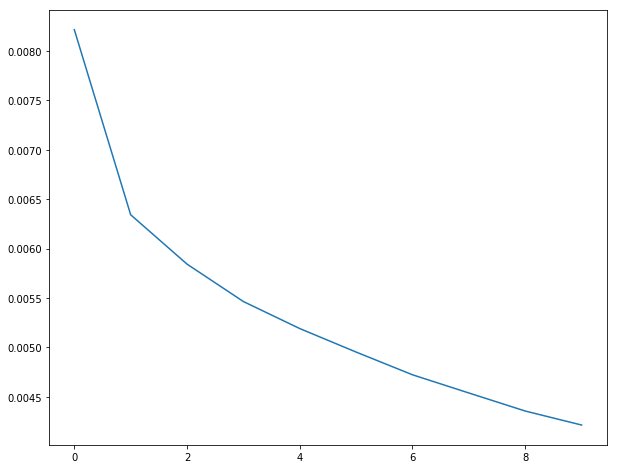

In [47]:
plt.figure(figsize=(10,8))
plt.plot(tl_)

In [48]:
ta_

[0.8899875,
 0.9192875,
 0.92635,
 0.93205,
 0.93545,
 0.938625,
 0.942275,
 0.9442,
 0.947225,
 0.948375]

In [49]:
va_

[0.9057, 0.914, 0.9124, 0.9149, 0.914, 0.9148, 0.9138, 0.9124, 0.9134, 0.9128]

In [20]:
with open("model_1.pkl","rb") as file:
    model_1 = pkl.load(file)

In [21]:
with open("model_9.pkl","rb") as file:
    model_9 = pkl.load(file)

In [50]:
#model_1.fc.weight

In [51]:
#model_9.fc.weight.data

In [24]:
#w1 = model_1.fc.weight

In [26]:
#w2 = model_9.fc.weight

In [27]:
#w9 = model_9.fc.weight

In [52]:
#torch.all(torch.eq(w1, w2))

In [53]:
#yelp_dataset.data[10]

In [54]:
test_loss, test_acc = test_func(test)

In [55]:
test_acc

0.9184